**Imports and includes**

In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys
import glob

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment analysis function provided by Upasana**

In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Create list of all Baseline Users**

In [5]:
all_user_lists=[
    '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_DidnotMentionBackUsers.csv',
    '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_MentionBackedUsers.csv']

UserList = []
userPathDict = {}
for i in range(2):  
    df = pd.read_csv(all_user_lists[i])
    tempUserList = list(df['Users'])
    for j in range(len(tempUserList)):
        UserList.append(tempUserList[j])
#         if (i == 0) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
#         elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
        if (i == 0) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
        elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
    

In [6]:
print("Number of possibly affected users: " + str(len(UserList)))

Number of possibly affected users: 2058


In [7]:
# with open('pau_all.txt', 'w') as filehandle:
#     for listitem in UserList:
#         filehandle.write('%s\n' % listitem)

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**

In [8]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [9]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Calculate monthy values for each user (over the 96 months from Jan 2009 to December 2016)**

In [10]:
timelineDict = {}

In [11]:
firstTweetIndexDict = {}

In [12]:
timelineDF = pd.DataFrame(columns=['username','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

In [13]:
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(100):
    try:
        #read in, reverse order (so oldest is first), reset index
        temp_user_db = pd.read_csv(userPathDict[UserList[i]]+UserList[i]+'.csv', header=None, low_memory=False)
        temp_user_db = temp_user_db.iloc[::-1]
        temp_user_db.reset_index(drop=True, inplace=True)

        #create lists for each metric
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        trump_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        clinton_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        positive_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        negative_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]

        #iterate through user tweets
        first = 1
        for j in range(len(temp_user_db)):

            #step one is assigning an index for the tweet, based on date, or disregarding
            found = 0
            tweetdate = dt.strptime(temp_user_db[3][j], "%Y-%m-%d")
            for k in range(2009,2017):
                temp_year = k
                date_start = dt(temp_year,1,1)
                date_end = dt(temp_year,12,31)
                if tweetdate < date_start:
                    continue;
                elif tweetdate <= date_end:
                    for m in range(2,14):
                        if m == 13: #month must be December by process of elimination
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;
                        next_month_start = dt(temp_year,m,1)
                        if tweetdate < next_month_start:
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;

            #tweet occurred within the period 2009-2016 and was assigned an valid index
            if found == 1:
                if first:
                    firstTweetIndexDict[UserList[i]] = use_index
                    first = 0

                tweet_count[use_index] +=1

                tweet_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                sentiment_scores[use_index].append(tweet_sent)

                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))

                if trump_flag: trump_count[use_index] += 1
                if clinton_flag: clinton_count[use_index] += 1

                if trump_flag and not clinton_flag: trump_sent[use_index].append(tweet_sent)
                if clinton_flag and not trump_flag: clinton_sent[use_index].append(tweet_sent)

                if tweet_sent > 0: positive_sent[use_index].append(tweet_sent)
                if tweet_sent < 0: negative_sent[use_index].append(tweet_sent)

        timelineDict[UserList[i]] = [tweet_count, sentiment_scores, trump_count, clinton_count, 
                                     trump_sent, clinton_sent, positive_sent, negative_sent]

        print(str(i) + " / " + size)

    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))

        

0 / 2058
1 / 2058
2 / 2058
3 / 2058
4 / 2058
5 / 2058
6 / 2058
7 / 2058
8 / 2058
9 / 2058
10 / 2058
11 / 2058
12 / 2058
13 / 2058
14 / 2058
15 / 2058
16 / 2058
17 / 2058
18 / 2058
19 / 2058
20 / 2058
21 / 2058
22 / 2058
23 / 2058
24 / 2058
25 / 2058
26 / 2058
27 / 2058
28 / 2058
29 / 2058
30 / 2058
31 / 2058
32 / 2058
33 / 2058
34 / 2058
35 / 2058
36 / 2058
37 / 2058
38 / 2058
39 / 2058
40 / 2058
41 / 2058
42 / 2058
43 / 2058
44 / 2058
45 / 2058
46 / 2058
47 / 2058
48 / 2058
49 / 2058
50 / 2058
51 / 2058
52 / 2058
53 / 2058
54 / 2058
55 / 2058
56 / 2058
57 / 2058
58 / 2058
59 / 2058
60 / 2058
61 / 2058
62 / 2058
63 / 2058
64 / 2058
65 / 2058
66 / 2058
67 / 2058
68 / 2058
69 / 2058
70 / 2058
71 / 2058
72 / 2058
73 / 2058
74 / 2058
75 / 2058
76 / 2058
77 / 2058
78 / 2058
79 / 2058
80 / 2058
81 / 2058
82 / 2058
83 / 2058
84 / 2058
85 / 2058
86 / 2058
87 / 2058
88 / 2058
89 / 2058
90 / 2058
91 / 2058
92 / 2058
93 / 2058
94 / 2058
95 / 2058
96 / 2058
97 / 2058
98 / 2058
99 / 2058
100 / 2058

755 / 2058
756 / 2058
757 / 2058
758 / 2058
759 / 2058
760 / 2058
761 / 2058
762 / 2058
763 / 2058
764 / 2058
765 / 2058
766 / 2058
767 / 2058
768 / 2058
769 / 2058
770 / 2058
771 / 2058
772 / 2058
773 / 2058
774 / 2058
775 / 2058
776 / 2058
777 / 2058
778 / 2058
779 / 2058
780 / 2058
781 / 2058
782 / 2058
783 / 2058
784 / 2058
785 / 2058
786 / 2058
787 / 2058
788 / 2058
789 / 2058
790 / 2058
791 / 2058
792 / 2058
793 / 2058
794 / 2058
795 / 2058
796 / 2058
797 / 2058
798 / 2058
799 / 2058
800 / 2058
801 / 2058
802 / 2058
803 / 2058
804 / 2058
805 / 2058
806 / 2058
807 / 2058
808 / 2058
809 / 2058
810 / 2058
811 / 2058
812 / 2058
813 / 2058
814 / 2058
815 / 2058
816 / 2058
817 / 2058
818 / 2058
819 / 2058
820 / 2058
821 / 2058
822 / 2058
823 / 2058
824 / 2058
825 / 2058
826 / 2058
827 / 2058
828 / 2058
829 / 2058
830 / 2058
831 / 2058
832 / 2058
833 / 2058
834 / 2058
835 / 2058
836 / 2058
837 / 2058
838 / 2058
839 / 2058
840 / 2058
841 / 2058
842 / 2058
843 / 2058
844 / 2058
845 / 2058

1476 / 2058
1477 / 2058
1478 / 2058
1479 / 2058
1480 / 2058
1481 / 2058
1482 / 2058
1483 / 2058
1484 / 2058
1485 / 2058
1486 / 2058
1487 / 2058
1488 / 2058
1489 / 2058
1490 / 2058
1491 / 2058
1492 / 2058
1493 / 2058
1494 / 2058
1495 / 2058
1496 / 2058
1497 / 2058
1498 / 2058
1499 / 2058
1500 / 2058
1501 / 2058
1502 / 2058
1503 / 2058
1504 / 2058
1505 / 2058
1506 / 2058
1507 / 2058
1508 / 2058
1509 / 2058
1510 / 2058
1511 / 2058
1512 / 2058
1513 / 2058
1514 / 2058
1515 / 2058
1516 / 2058
1517 / 2058
1518 / 2058
1519 / 2058
1520 / 2058
1521 / 2058
1522 / 2058
1523 / 2058
1524 / 2058
1525 / 2058
1526 / 2058
1527 / 2058
1528 / 2058
1529 / 2058
1530 / 2058
1531 / 2058
1532 / 2058
1533 / 2058
1534 / 2058
1535 / 2058
1536 / 2058
1537 / 2058
1538 / 2058
1539 / 2058
1540 / 2058
1541 / 2058
1542 / 2058
1543 / 2058
1544 / 2058
1545 / 2058
1546 / 2058
1547 / 2058
1548 / 2058
1549 / 2058
1550 / 2058
1551 / 2058
1552 / 2058
1553 / 2058
1554 / 2058
1555 / 2058
1556 / 2058
1557 / 2058
1558 / 2058
1559

In [14]:
len(firstTweetIndexDict)

1888

In [15]:
for i in range(len(timelineDF)):
    try:
        test = firstTweetIndexDict[timelineDF['username'][i]]
    except:
        print(timelineDF['username'][i] + ' failed [' +str(i)+']' )

In [16]:
timelineDF = pd.DataFrame.from_dict(timelineDict, orient='index',columns=['tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

timelineDF.index.name = 'username'
timelineDF.reset_index(inplace=True)


In [17]:
len(timelineDF)

2058

In [18]:
tweet_countDict = {}
sentiment_scoresDict = {}
trump_countDict = {}
clinton_countDict = {}
trump_sentDict = {}
clinton_sentDict = {}
positive_sentDict = {}
negative_sentDict = {} 

In [19]:
size = str(len(timelineDF))
for i in range(len(timelineDF)):
    try:
        start_index = firstTweetIndexDict[timelineDF['username'][i]]

        tweet_count = []
        sentiment_scores = []
        trump_count = []
        clinton_count = []
        trump_sent = []
        clinton_sent = []
        positive_sent = []
        negative_sent = [] 

        for j in range(0,96):
            if j >= start_index:
                tweet_count.append(timelineDF['tweet_count'][i][j])
                trump_count.append(timelineDF['trump_count'][i][j])
                clinton_count.append(timelineDF['clinton_count'][i][j])

                if(len(timelineDF['sentiment_scores'][i][j]) > 0):
                    sentiment_scores.append(statistics.mean(timelineDF['sentiment_scores'][i][j]))
                else:
                    sentiment_scores.append(np.nan)

                if(len(timelineDF['trump_sent'][i][j]) > 0):
                    trump_sent.append(statistics.mean(timelineDF['trump_sent'][i][j]))
                else:
                    trump_sent.append(np.nan)

                if(len(timelineDF['clinton_sent'][i][j]) > 0):
                    clinton_sent.append(statistics.mean(timelineDF['clinton_sent'][i][j]))
                else:
                    clinton_sent.append(np.nan)

                if(len(timelineDF['positive_sent'][i][j]) > 0):
                    positive_sent.append(statistics.mean(timelineDF['positive_sent'][i][j]))
                else:
                    positive_sent.append(np.nan)

                if(len(timelineDF['negative_sent'][i][j]) > 0):
                    negative_sent.append(statistics.mean(timelineDF['negative_sent'][i][j]))
                else:
                    negative_sent.append(np.nan)

            else:
                tweet_count.append(np.nan)
                trump_count.append(np.nan)
                clinton_count.append(np.nan)
                sentiment_scores.append(np.nan)
                trump_sent.append(np.nan)
                clinton_sent.append(np.nan)
                positive_sent.append(np.nan)
                negative_sent.append(np.nan)

        tweet_countDict[timelineDF['username'][i]] = tweet_count
        sentiment_scoresDict[timelineDF['username'][i]] = sentiment_scores
        trump_countDict[timelineDF['username'][i]] = trump_count
        clinton_countDict[timelineDF['username'][i]] = clinton_count
        trump_sentDict[timelineDF['username'][i]] = trump_sent
        clinton_sentDict[timelineDF['username'][i]] = clinton_sent
        positive_sentDict[timelineDF['username'][i]] = positive_sent
        negative_sentDict[timelineDF['username'][i]] =  negative_sent 

        print(str(i) + " / " + size)
        
    except Exception as e: 
        print(str(timelineDF['username'][i]) + " failed - " + str(e))

0 / 2058
1 / 2058
2 / 2058
hashtagnpisces failed - 'hashtagnpisces'
4 / 2058
rocketmanxl1 failed - 'rocketmanxl1'
csbjaf failed - 'csbjaf'
7 / 2058
8 / 2058
9 / 2058
10 / 2058
11 / 2058
12 / 2058
13 / 2058
14 / 2058
15 / 2058
16 / 2058
17 / 2058
AuspiciousAei failed - 'AuspiciousAei'
19 / 2058
20 / 2058
21 / 2058
22 / 2058
23 / 2058
24 / 2058
25 / 2058
26 / 2058
27 / 2058
28 / 2058
budgieofdespair failed - 'budgieofdespair'
30 / 2058
31 / 2058
drivn2xl failed - 'drivn2xl'
33 / 2058
34 / 2058
35 / 2058
36 / 2058
37 / 2058
CaptainNeil96 failed - 'CaptainNeil96'
39 / 2058
40 / 2058
41 / 2058
42 / 2058
43 / 2058
44 / 2058
45 / 2058
46 / 2058
47 / 2058
48 / 2058
needajobbad failed - 'needajobbad'
50 / 2058
51 / 2058
52 / 2058
53 / 2058
54 / 2058
55 / 2058
56 / 2058
57 / 2058
58 / 2058
59 / 2058
60 / 2058
61 / 2058
62 / 2058
63 / 2058
64 / 2058
65 / 2058
66 / 2058
67 / 2058
68 / 2058
69 / 2058
70 / 2058
71 / 2058
72 / 2058
73 / 2058
74 / 2058
75 / 2058
76 / 2058
77 / 2058
78 / 2058
79 / 2058

615 / 2058
gyus777 failed - 'gyus777'
617 / 2058
618 / 2058
619 / 2058
620 / 2058
621 / 2058
622 / 2058
623 / 2058
624 / 2058
625 / 2058
626 / 2058
tracyisland6 failed - 'tracyisland6'
628 / 2058
629 / 2058
630 / 2058
631 / 2058
632 / 2058
633 / 2058
634 / 2058
635 / 2058
636 / 2058
637 / 2058
638 / 2058
639 / 2058
640 / 2058
641 / 2058
642 / 2058
643 / 2058
644 / 2058
645 / 2058
646 / 2058
647 / 2058
648 / 2058
649 / 2058
650 / 2058
651 / 2058
652 / 2058
653 / 2058
654 / 2058
655 / 2058
656 / 2058
657 / 2058
658 / 2058
659 / 2058
660 / 2058
661 / 2058
LelJoyce failed - 'LelJoyce'
663 / 2058
664 / 2058
665 / 2058
whyitmatters failed - 'whyitmatters'
667 / 2058
668 / 2058
669 / 2058
670 / 2058
671 / 2058
672 / 2058
__ninasimone failed - '__ninasimone'
674 / 2058
Tufftruth failed - 'Tufftruth'
676 / 2058
677 / 2058
678 / 2058
679 / 2058
680 / 2058
681 / 2058
682 / 2058
683 / 2058
684 / 2058
685 / 2058
RJ13835606 failed - 'RJ13835606'
687 / 2058
688 / 2058
689 / 2058
690 / 2058
691 / 2058

1195 / 2058
Thirsty_Grunt failed - 'Thirsty_Grunt'
1197 / 2058
1198 / 2058
1199 / 2058
1200 / 2058
1201 / 2058
1202 / 2058
mypostdemise failed - 'mypostdemise'
1204 / 2058
1205 / 2058
1206 / 2058
1207 / 2058
1208 / 2058
1209 / 2058
1210 / 2058
1211 / 2058
1212 / 2058
1213 / 2058
1214 / 2058
donttreadupon failed - 'donttreadupon'
1216 / 2058
1217 / 2058
1218 / 2058
QQBeautifulDove failed - 'QQBeautifulDove'
1220 / 2058
1221 / 2058
1222 / 2058
1223 / 2058
1224 / 2058
1225 / 2058
1226 / 2058
1227 / 2058
1228 / 2058
1229 / 2058
1230 / 2058
1231 / 2058
1232 / 2058
boom_damn failed - 'boom_damn'
1234 / 2058
1235 / 2058
1236 / 2058
1237 / 2058
1238 / 2058
1239 / 2058
1240 / 2058
1241 / 2058
1242 / 2058
1243 / 2058
1244 / 2058
1245 / 2058
1246 / 2058
1247 / 2058
1248 / 2058
ftalke failed - 'ftalke'
1250 / 2058
1251 / 2058
1252 / 2058
1253 / 2058
1254 / 2058
1255 / 2058
1256 / 2058
1257 / 2058
AliciaBeck20 failed - 'AliciaBeck20'
1259 / 2058
1260 / 2058
1261 / 2058
1262 / 2058
1263 / 2058
1264 

1809 / 2058
1810 / 2058
1811 / 2058
TaveresQuixote failed - 'TaveresQuixote'
1813 / 2058
1814 / 2058
1815 / 2058
1816 / 2058
1817 / 2058
1818 / 2058
1819 / 2058
1820 / 2058
1821 / 2058
1822 / 2058
1823 / 2058
1824 / 2058
1825 / 2058
1826 / 2058
1827 / 2058
1828 / 2058
1829 / 2058
1830 / 2058
1831 / 2058
1832 / 2058
1833 / 2058
1834 / 2058
1835 / 2058
1836 / 2058
1837 / 2058
1838 / 2058
1839 / 2058
1840 / 2058
1841 / 2058
1842 / 2058
1843 / 2058
1844 / 2058
1845 / 2058
1846 / 2058
1847 / 2058
1848 / 2058
1849 / 2058
1850 / 2058
1851 / 2058
1852 / 2058
1853 / 2058
1854 / 2058
1855 / 2058
1856 / 2058
1857 / 2058
1858 / 2058
1859 / 2058
1860 / 2058
1861 / 2058
1862 / 2058
1863 / 2058
1864 / 2058
1865 / 2058
1866 / 2058
1867 / 2058
1868 / 2058
1869 / 2058
1870 / 2058
1871 / 2058
1872 / 2058
1873 / 2058
1874 / 2058
1875 / 2058
1876 / 2058
1877 / 2058
1878 / 2058
1879 / 2058
1880 / 2058
1881 / 2058
1882 / 2058
1883 / 2058
1884 / 2058
1885 / 2058
1886 / 2058
1887 / 2058
1888 / 2058
1889 / 2058

In [20]:
tweet_countDF = pd.DataFrame.from_dict(tweet_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
tweet_countDF.index.name = 'username'
tweet_countDF.reset_index(inplace=True)
tweet_countDF = tweet_countDF.drop(columns=['username'])

trump_countDF = pd.DataFrame.from_dict(trump_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_countDF.index.name = 'username'
trump_countDF.reset_index(inplace=True)
trump_countDF = trump_countDF.drop(columns=['username'])

clinton_countDF = pd.DataFrame.from_dict(clinton_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_countDF.index.name = 'username'
clinton_countDF.reset_index(inplace=True)
clinton_countDF = clinton_countDF.drop(columns=['username'])

sentiment_scoresDF = pd.DataFrame.from_dict(sentiment_scoresDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
sentiment_scoresDF.index.name = 'username'
sentiment_scoresDF.reset_index(inplace=True)
sentiment_scoresDF = sentiment_scoresDF.drop(columns=['username'])

trump_sentDF = pd.DataFrame.from_dict(trump_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_sentDF.index.name = 'username'
trump_sentDF.reset_index(inplace=True)
trump_sentDF = trump_sentDF.drop(columns=['username'])

clinton_sentDF = pd.DataFrame.from_dict(clinton_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_sentDF.index.name = 'username'
clinton_sentDF.reset_index(inplace=True)
clinton_sentDF = clinton_sentDF.drop(columns=['username'])

positive_sentDF = pd.DataFrame.from_dict(positive_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
positive_sentDF.index.name = 'username'
positive_sentDF.reset_index(inplace=True)
positive_sentDF = positive_sentDF.drop(columns=['username'])

negative_sentDF = pd.DataFrame.from_dict(negative_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
negative_sentDF.index.name = 'username'
negative_sentDF.reset_index(inplace=True)
negative_sentDF = negative_sentDF.drop(columns=['username'])

In [21]:
timelineDF.to_pickle("./NON_PAU_timelineDF_090320.pkl")

In [22]:
tweet_countDF.to_pickle("./NON_PAU_tweet_countDF_090320.pkl")
trump_countDF.to_pickle("./NON_PAU_trump_countDF_090320.pkl")
clinton_countDF.to_pickle("./NON_PAU_clinton_countDF_090320.pkl")
sentiment_scoresDF.to_pickle("./NON_PAU_sentiment_scoresDF_090320.pkl")
trump_sentDF.to_pickle("./NON_PAU_trump_sentDF_090320.pkl")
clinton_sentDF.to_pickle("./NON_PAU_clinton_sentDF_090320.pkl")
positive_sentDF.to_pickle("./NON_PAU_positive_sentDF_090320.pkl")
negative_sentDF.to_pickle("./NON_PAU_negative_sentDF_090320.pkl")


In [23]:
# unpickled_df = pd.read_pickle("./negative_sentDF_090320.pkl")

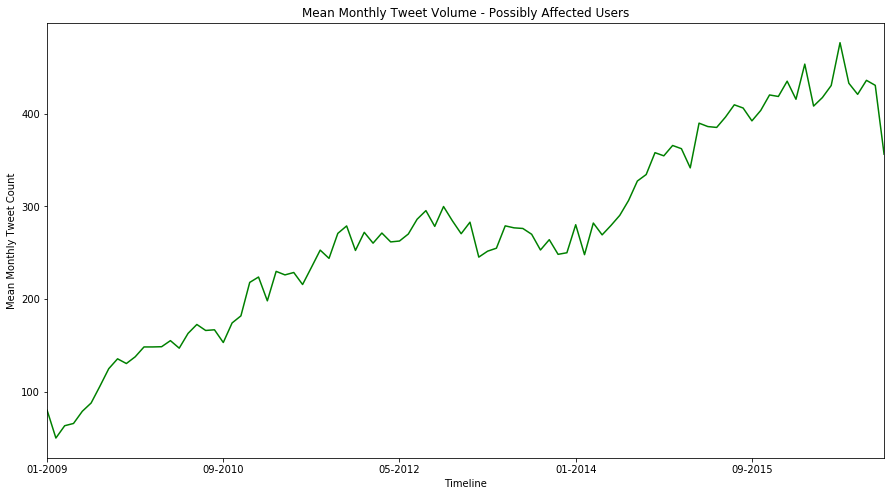

In [24]:
plt.figure()
tweet_countDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Mean Monthly Tweet Volume - Possibly Affected Users')
# plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Tweet Count')
plt.xlabel('Timeline')
plt.savefig('PAU_graphics/NON_pau_tweetcount.png')
plt.show()

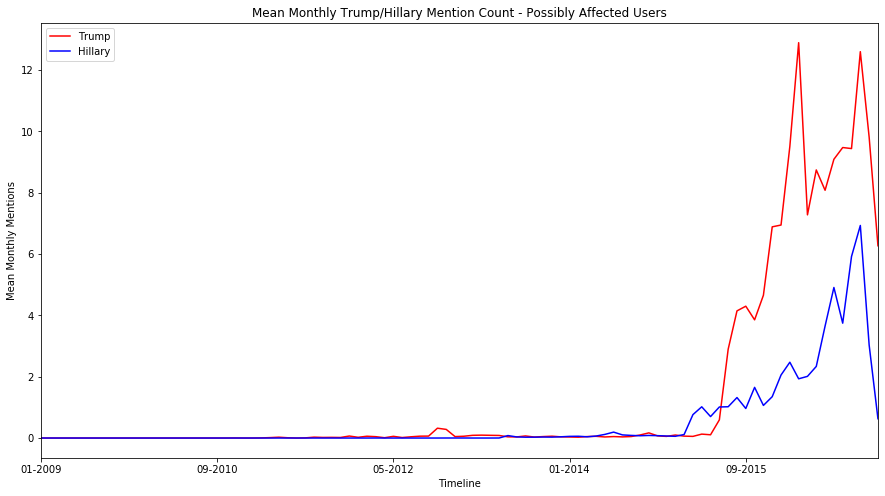

In [25]:
plt.figure()
trump_countDF.mean().plot(kind='line', color='red', figsize=(15,8),title='Mean Monthly Trump/Hillary Mention Count - Possibly Affected Users')
clinton_countDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Mentions')
plt.savefig('PAU_graphics/NON_pau_mentions.png')
plt.xlabel('Timeline')
plt.show()

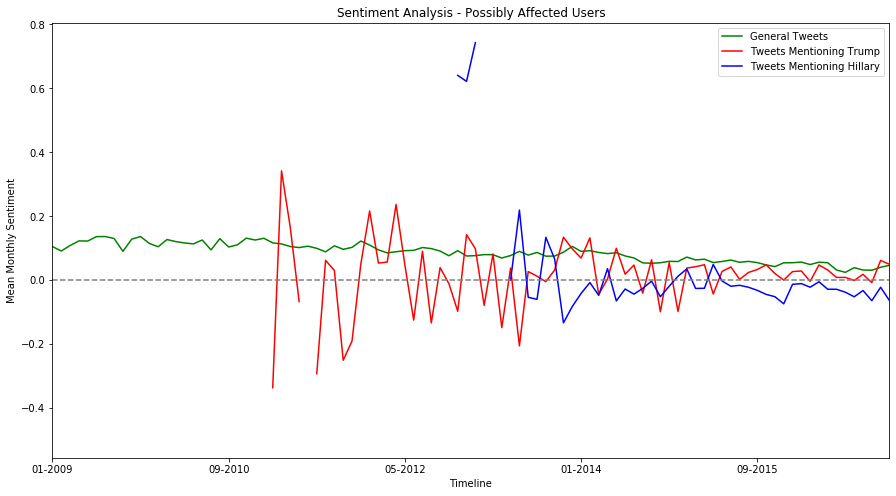

In [26]:
plt.figure()
sentiment_scoresDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Sentiment Analysis - Possibly Affected Users')
trump_sentDF.mean().plot(kind='line', color='red', figsize=(15,8))
clinton_sentDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('General Tweets','Tweets Mentioning Trump','Tweets Mentioning Hillary'))
plt.axhline(0, color="grey", linestyle="--")
plt.ylabel('Mean Monthly Sentiment')
plt.savefig('PAU_graphics/NON_pau_sentiment.png')
plt.xlabel('Timeline')
plt.show()